<h1 style="font-family:Inter;font-size:36px;text-align:center;background-color:#c4f2b3;padding:20px;border-radius:10px"> 
    Introduction </h1>

<div style="font-family:Inter;font-size:18px"><b style="background-color:#d8fde8; padding:5px">Objectives:</b>
<ul style="font-family:Inter;font-size:16px">
    <li>Make an exploratory data analysis on a FIFA dataset, exploring new ways of data visualization and completing the process of scraping, cleaning and analyzing. <b>I hope you enjoy!</b></li>
</ul>
</div>

<div style="font-family:Inter;font-size:18px"><b style="background-color:#d8fde8; padding:5px">The Dataset:</b>
<ul style="font-family:Inter;font-size:16px">
    <li>The dataset was part of a project of scraping, cleaning and analysis. The scraping process is in this <a href="https://www.kaggle.com/code/lucas142129silva/fifa-23-players-scraping">notebook</a>.</li>
    <li>The dataset has the data for every player in FIFA 23 ultimate team, with their attributes, price and popularity. It can be used for an EDA or for a Machine Learning Process to predict a player price.</li>
</ul>
    <img src="https://www.fifa-infinity.com/wp-content/uploads/2022/11/fifa23-world-cup-fut-620x330.jpg"></img>
</div>

<div style="font-family:Inter;font-size:18px"><b style="background-color:#d8fde8; padding:5px">Technologies Used:</b>
<ul style="font-family:Inter;font-size:16px">
    <li> Matplolib, Seaborn and CV2 for Data Visualization</li>
    <li> Pandas, Seaborn as Regular Expressions for Data Manipulation</li>
    <li> URLLib, Requests and Beautiful Soup for Web Scraping</li>
</ul>
</div>

<h1 style="font-family:Inter;font-size:36px;text-align:center;background-color:#c4f2b3;padding:20px;border-radius:10px"> 
    Imports </h1>

In [1]:
# -- Data Manipulation -- #
import numpy as np 
import pandas as pd
import re

# -- Web Scraping -- #
from urllib.request import Request, urlopen, urlretrieve
import urllib
from bs4 import BeautifulSoup
import cv2
import requests

# -- Data Visualization -- #
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.font_manager as fm

# -- Sleep for requests and ignore warnings -- #
from time import sleep
import warnings
warnings.filterwarnings("ignore")

# -- Dir manipulation -- #
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fifa-23-ultimate-team-players-database/fifa23_players_2023-01-14.csv


In [2]:
# -- Get the Font -- #
os.mkdir("./fonts")
url = "https://github.com/lucas142129silva/Movies-Exploratory-Data-Analysis/blob/main/fonts/FRAMD_M.ttf?raw=true"
r = requests.get(url)
with open("./fonts/framd_m.ttf", "wb") as f:
    f.write(r.content)
    
font = fm.FontProperties(fname="./fonts/framd_m.ttf")

<h1 style="font-family:Inter;font-size:36px;text-align:center;background-color:#c4f2b3;padding:20px;border-radius:10px"> Requests Functions </h1>

<div style="font-family:Inter;font-size:18px"><b style="background-color:#d8fde8; padding:5px">This section contains all the requests for searching functions, including search for a player image, a nation flag and a club badge. All of them request the images from futbin.</b></div>

In [3]:
os.mkdir("./players")
os.mkdir("./clubs")
os.mkdir("./nations")

In [4]:
# -- Web Scraping -- #
def authentication_url(url):
    headers = {'User-Agent': 'Mozilla/5.0'}
    req = Request(url, headers=headers)
    response = urlopen(req)
    html = response.read()

    soup_a = BeautifulSoup(html, 'html.parser')
    return soup_a


# -- Players -- #
def process_name(player_name):
    """Clean characters for a better search"""
    p_name = player_name.lower()
    p_name = re.sub("[áãâäà]", "a", p_name)
    p_name = re.sub("[éêèë]", "e", p_name)
    p_name = re.sub("[íïîì]", "i", p_name)
    p_name = re.sub("[õóòôö]", "o", p_name)
    p_name = re.sub("[úùüû]", "u", p_name)
    p_name = re.sub("[ñ]", "n", p_name)
    p_name = p_name.replace(" ", "%20")
    return p_name


def get_player_image(player_name):
    p_name = process_name(player_name)
    filename = "./players/" + p_name.replace("%20", "_") + ".png"
    arq = filename.split("/")[-1]
    
    if arq not in os.listdir("./players"): 
        url_query = "https://www.futbin.com/players?page=1&search=" + p_name
        soup_q = authentication_url(url_query)

        img_url = soup_q.find("tr").find("img")['data-original']
        img_data = requests.get(img_url).content

        with open(filename, 'wb') as f:
            f.write(img_data)

    picture = plt.imread(filename)
    resized = cv2.resize(picture, (160, 160), interpolation = cv2.INTER_AREA)
    
    return resized


# -- Clubs -- #
def get_club_image(club_name):
    c_name = process_name(club_name).replace("%20", "_")
    search_name = process_name(club_name).replace("%20", " ")
    
    # If a club has spacebar in its name, searchs only the first word 
    query_name = c_name.split("_")[0]
    filename = "./clubs/" + c_name + ".png"
    arq = filename.split("/")[-1]
    
    if arq not in os.listdir("./clubs"): 
        url_query = url = "https://www.futbin.com/clubs?page=1&sort=gold_count&order=desc&search=" + query_name
        soup_q = authentication_url(url_query)
        
        # Search for every 'tr' in page and check the club name
        page_tags = soup_q.find_all("tr")
        clubs_vector = [tr.find("a").get_text(strip=True).lower() for tr in soup_q.find_all("tr")]
        club_index = clubs_vector.index(search_name)
        img_url = page_tags[club_index].find("img")['src']
        img_data = requests.get(img_url).content

        with open(filename, 'wb') as f:
            f.write(img_data)

    picture = plt.imread(filename)
    resized = cv2.resize(picture, (140, 140), interpolation = cv2.INTER_AREA)
    return resized


# -- Nations -- #
def exceptional_nations(nation_name):
    filename = "./nations/" + nation_name.replace(" ", "_") + ".png"
    arq = filename.split("/")[-1] 
    
    if arq not in os.listdir("./nations"):
        """Nations with more than 1 word get exceptional treatment, because of the FUTBIN Search system"""
        search_nation = process_name(nation_name).replace("%20", " ").split(" ")[0]
        nation_query = "https://www.futbin.com/23/nations?page=1&sort=gold_count&order=desc&search=" + search_nation
        soup_e = authentication_url(nation_query)

        """Searchs for the first word of nation and lists all of them, after that, search by the name going through
        the texts"""
        nations_returned = soup_e.find_all("tr")
        index = [i.find("a").getText(strip=True) for i in nations_returned].index(nation_name)
        img_url = nations_returned[index].find('img')['src']
        img_data = requests.get(img_url).content
    
        """Saving the image"""
        with open(filename, 'wb') as f:
                f.write(img_data)
    
    return arq


def get_nation_image(nation):
    """Format the Nation Name to find it"""
    nation_name = process_name(nation).replace("%20", " ") + ".png"
    
    if len(nation_name.split(" ")) > 1:
        nation_name = exceptional_nations(nation)
    
    filename = "./nations/" + nation_name
    
    """If the nation flag is not in the dir yet, it scrapes and downloads it. That way, it is faster
    to find the nations images when it already is downloaded."""
    if nation_name not in os.listdir("./nations"):
        # Scraping
        nation_query = "https://www.futbin.com/23/nations?page=1&sort=gold_count&order=desc&search=" + nation
        soup_n = authentication_url(nation_query)
        img_url = soup_n.find('tr').find('img')['src']
        img_data = requests.get(img_url).content

        with open(filename, 'wb') as f:
            f.write(img_data)
        
    picture = cv2.imread(filename)
    picture = cv2.cvtColor(picture, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(picture, (70, 42), interpolation = cv2.INTER_AREA)
   
    return resized

<h1 style="font-family:Inter;font-size:36px;background-color:#c4f2b3;padding:20px;border-radius:10px;text-align:center"> 
    Understading the Data</h1>

In [5]:
players_df = pd.read_csv("/kaggle/input/fifa-23-ultimate-team-players-database/fifa23_players_2023-01-14.csv")
players_df.head()

,Name,Club,Nation,League,Rating,Main_Position,Alternate_Positions,Card_Version,Run_Style,Price,...,Shooting / Handling,Passing / Kicking,Dribbling / Reflexes,Defense / Speed,Physical / Positioning,Height,BodyType,Popularity,Base_Stats,Ingame_Stats
0,Pelé,FUT ICONS,Brazil,Icons,98,CAM,"CF,ST",Icon,Explosive,4150000.0,...,96,93,96,60,76,"173cm | 5'8""",Unique (70kg),2984,516,2513
1,Ronaldo,FUT ICONS,Brazil,Icons,96,ST,CF,Icon,Controlled,8270000.0,...,95,81,95,45,76,"183cm | 6'0""",R9 (78kg),3225,489,2341
2,Zinedine Zidane,FUT ICONS,France,Icons,96,CAM,CM,Icon,Controlled,2630000.0,...,92,96,95,75,86,"185cm | 6'1""",Average (77kg),1194,529,2548
3,Pelé,FUT ICONS,Brazil,Icons,96,CF,"CAM,ST",World Cup ICON,Explosive,3590000.0,...,94,92,95,58,75,"173cm | 5'8""",Unique (70kg),938,510,2475
4,Pelé,FUT ICONS,Brazil,Icons,95,CF,"CAM,ST",Icon,Explosive,2720000.0,...,93,90,95,56,75,"173cm | 5'8""",Unique (69kg),1788,505,2452


In [6]:
players_df.isna().sum()

Name                      0
Club                      0
Nation                    0
League                    0
Rating                    0
Main_Position             0
Alternate_Positions       0
Card_Version              0
Run_Style                 0
Price                     0
Price_Variation           0
Skills_Star               0
Weak_Foot_Star            0
Attack_Workrate           0
Defense_Workrate          0
Pace / Diving             0
Shooting / Handling       0
Passing / Kicking         0
Dribbling / Reflexes      0
Defense / Speed           0
Physical / Positioning    0
Height                    0
BodyType                  0
Popularity                0
Base_Stats                0
Ingame_Stats              0
dtype: int64

In [7]:
players_df.describe()

,Rating,Price,Skills_Star,Weak_Foot_Star,Pace / Diving,Shooting / Handling,Passing / Kicking,Dribbling / Reflexes,Defense / Speed,Physical / Positioning,Popularity,Base_Stats,Ingame_Stats
count,18355.000000,1.835500e+04,18355.000000,18355.000000,18355.000000,18355.000000,18355.000000,18355.000000,18355.000000,18355.000000,18355.000000,18355.000000,18355.00000
mean,68.362626,1.532312e+04,1.979788,3.004358,69.754181,56.413239,60.588777,65.615418,52.090929,66.919314,56.808608,371.383274,1645.37897
std,8.612764,1.532619e+05,1.364918,0.724261,11.537552,15.013794,11.073875,10.643183,16.915618,10.081534,355.207645,48.046293,378.71797
min,46.000000,0.000000e+00,0.000000,0.000000,28.000000,18.000000,26.000000,28.000000,15.000000,30.000000,-4647.000000,224.000000,536.00000
25%,63.000000,2.000000e+02,0.000000,3.000000,63.000000,46.000000,53.000000,59.000000,38.000000,60.000000,0.000000,338.000000,1506.00000
50%,67.000000,6.000000e+02,2.000000,3.000000,70.000000,58.000000,60.000000,66.000000,55.000000,68.000000,1.000000,368.000000,1694.00000
75%,73.000000,7.000000e+02,3.000000,3.000000,78.000000,67.000000,68.000000,72.000000,65.000000,74.000000,4.000000,401.000000,1875.00000
max,98.000000,8.270000e+06,5.000000,5.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,18636.000000,531.000000,2566.00000


<h1 style="font-family:Inter;font-size:36px;text-align:center;background-color:#c4f2b3;padding:20px;border-radius:10px"> 
    Players and Positions </h1>

<h2 style="font-family:Inter; font-size:24px">Get the Positions</h2>
<hr style="background-color:#498765; height:10px"></hr>
<p style="font-family:Inter; font-size:16px">The positions in FIFA can be expressed in graph, using a <b>7x5 rectangle</b>. Now, I created a DataFrame containing (x, y) coordinates for each position</p>

In [8]:
positions_coordinates = pd.DataFrame({"GK": [2.5, 0, "GK"],
                                      "RWB": [5, 2, "DEF"],
                                      "RB": [4, 1, "DEF"],
                                      "CB": [2.5, 1.25, "DEF"],
                                      "LB": [1, 1, "DEF"],
                                      "LWB": [0, 2, "DEF"],
                                      "CDM": [3.25, 2.25, "MID"],
                                      "CM": [2, 3, "MID"],
                                      "CAM": [3, 4, "MID"],
                                      "LM": [0, 3.75, "MID"],
                                      "RM": [5, 3.75, "MID"],
                                      "LW": [0, 5.5, "ATA"],
                                      "RW": [5, 5.5, "ATA"],
                                      "CF": [2, 5, "ATA"],
                                      "ST": [3, 6, "ATA"]}).T
positions_coordinates.columns = ["X", "Y", "Position_Area"]
positions_coordinates

,X,Y,Position_Area
GK,2.5,0,GK
RWB,5,2,DEF
RB,4,1,DEF
CB,2.5,1.25,DEF
LB,1,1,DEF
LWB,0,2,DEF
CDM,3.25,2.25,MID
CM,2,3,MID
CAM,3,4,MID
LM,0,3.75,MID


<h2 style="font-family:Inter; font-size:24px">Example of a field</h2>
<hr style="background-color:#498765; height:10px"></hr>

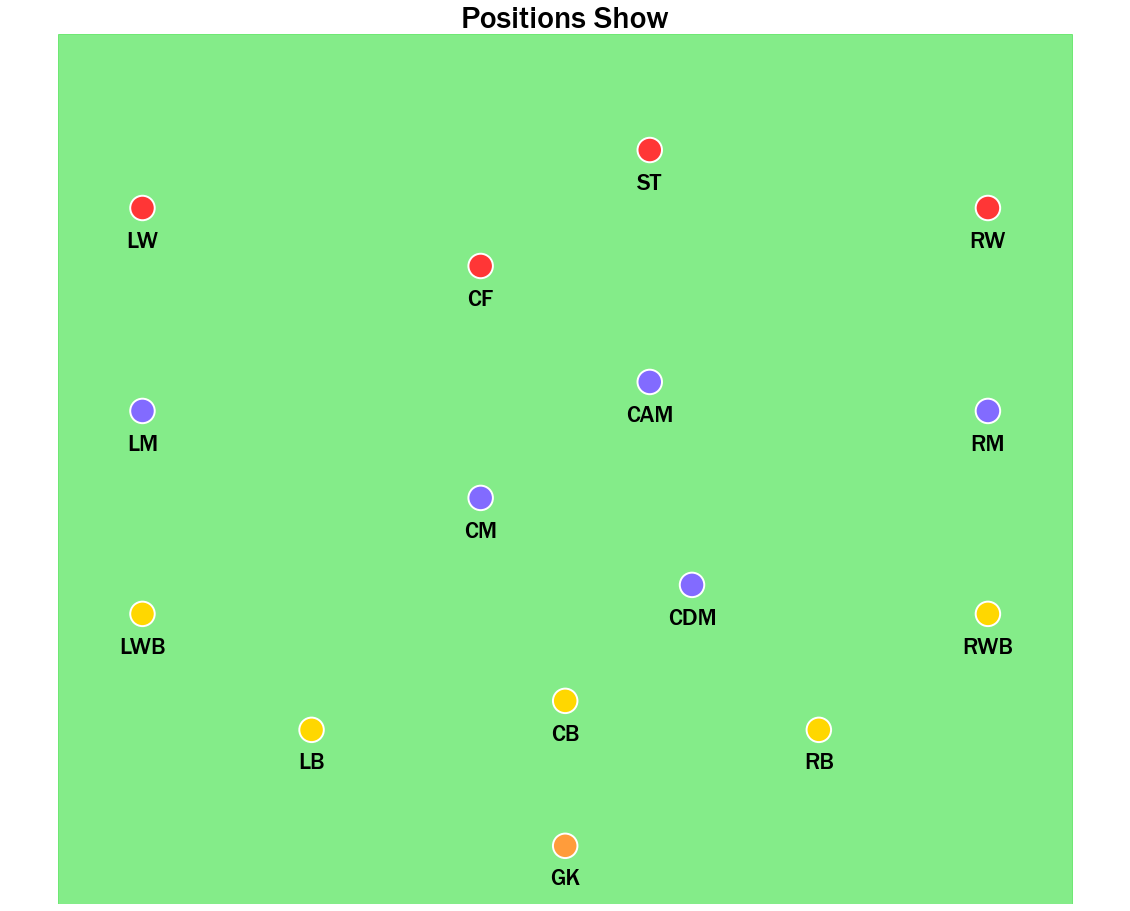

In [9]:
def make_field(dots=True):
    plt.axvspan(xmin=-0.5, xmax=5.5, color="#43e24a", alpha=0.65)
    palette = ["#ff9c3b", "#ffd700", "#826bff", "#ff3636"]
    
    s = 600 if dots else 0
    ax = sns.scatterplot(data=positions_coordinates, x="X", y="Y", 
                         s=s, hue="Position_Area", palette=palette)
    
    ax.figure.set_size_inches(20, 16)

    plt.ylim(ymin=-0.5, ymax=7)

    for index, row in positions_coordinates.iterrows():
        plt.text(s=str(index), x=row["X"], y = row["Y"] - 0.375,
                ha="center", va="bottom", font=font, fontsize=24)

    ax.axis("off")
    ax.legend().set_visible(False)
    return ax

ax = make_field()
ax.set_title("Positions Show", font=font, fontsize=32)
plt.show()

<h2 style="font-family:Inter; font-size:24px">Most Expensive Team per Position</h2>
<hr style="background-color:#498765; height:10px"></hr>
<p style="font-family:Inter; font-size:16px">Firstly, it needs to get the player image, so it scrapes by searching the player in futbin and get the first player picture. The searching function is <a href="#requests-functions">here</a> together with the cleaning name function. These are some examples:</p>
<p style="font-family:Inter; font-size:16px">In order to get a better visualization, it joins the players dataset with the positions coordinates dataset, so each player will be displayed on their own position on field.</p>

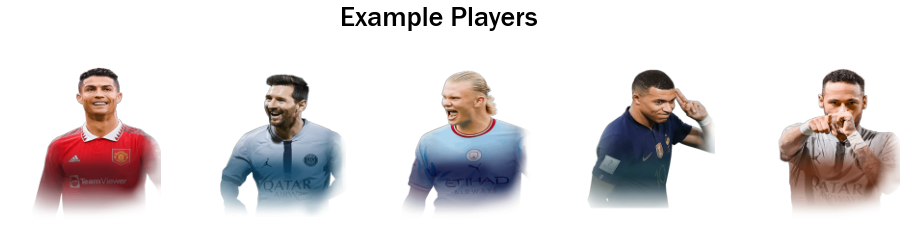

In [10]:
example = ["Cristiano Ronaldo", "Messi", "Haaland", "Mbappé", "Neymar"]

plt.figure(figsize=(16, 4))
for e, p in enumerate(example):
    plt.subplot(1, 5, e + 1)
    plt.imshow(get_player_image(p))
    plt.axis("off")

plt.suptitle("Example Players", font=font, fontsize=28)    
plt.show()

In [11]:
expensive_position = pd.DataFrame([])
price_sorted = players_df.sort_values("Price", ascending=False)

for pos in positions_coordinates.index:
        player = price_sorted.query("Main_Position == '%s'" % pos).iloc[:1]
        expensive_position = pd.concat([expensive_position, player])
        
expensive_position = expensive_position[["Name", "Main_Position", "Price"]].set_index("Main_Position")
expensive_position = expensive_position.join(positions_coordinates[["X", "Y"]])
expensive_position.head(1)

,Name,Price,X,Y
Main_Position,,,,
GK,Lev Yashin,825000.0,2.5,0


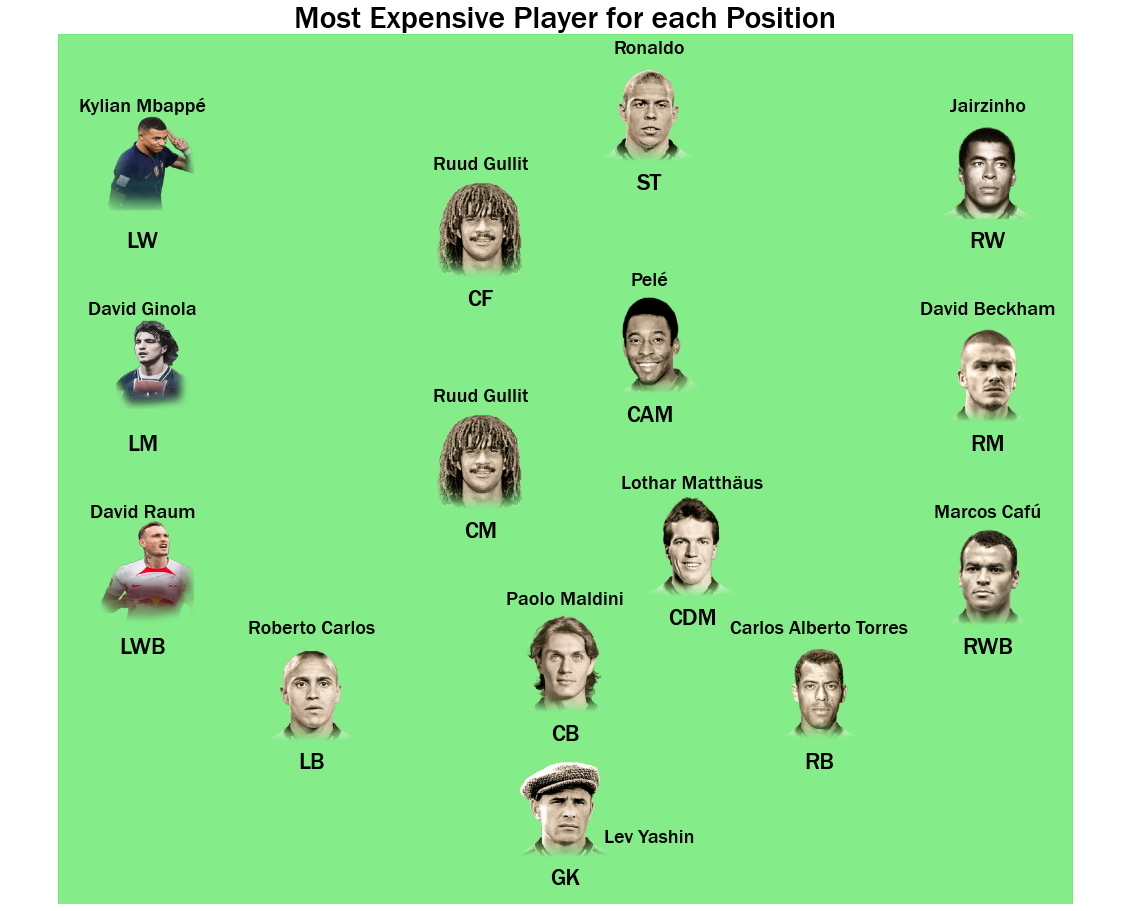

In [12]:
ax = make_field(False)

for index, row in expensive_position.iterrows():
    x = row["X"]
    y = row["Y"]
    
    # Player Name
    ## Put the Goalkeeper Name on side instead of above
    if index == "GK":
        plt.text(s=row["Name"], x=x + 0.5, y=y, font=font, 
                 fontsize=20, ha="center", va="bottom")
    else:
        plt.text(s=row["Name"], x=x, y = y + 0.8, font=font, 
                 fontsize=20, ha="center", va="bottom")
    
    # Player Image
    imagebox = OffsetImage(get_player_image(row['Name']), zoom=0.65)
    ab = AnnotationBbox(imagebox, (x, y + 0.35), frameon=False)
    ax.add_artist(ab)

ax.set_title("Most Expensive Player for each Position", font=font, fontsize=32)
plt.show()

<ul style="font-family:Inter;font-size:16px;padding:30px;border: 6px solid #69d071;border-radius:20px;line-height:30px">
<li><b>12 out of 15 are icons in football and in the game</b>, meaning his price is high because of how good they are in game and how famous they are for the football history.</li>
<li><b>Mbappé and Ginola are there because they are in the meta of the game</b>, they both are skillful and have a great control with both feet, besides being fast. The reason why these features influence the player price are in the topic <a href="#po_wf_sk_rs">Position, Weak Foot, Skills and Run Style</a> on <cite>What does the most expensive players have in common?</cite></li>
</ul>

<h2 style="font-family:Inter; font-size:24px">Most Popular Team per Position</h2>
<hr style="background-color:#498765; height:10px"></hr>
<p id="pop_per_pos" style="font-family:Inter; font-size:16px">Popularity on futbin is measured by the number of likes and dislikes in a player card. The users take into consideration <b>how is the player in real life</b>, if it is a <b>good card</b> and if the <b>price is reasonable</b>.</p>

In [13]:
popular_players = pd.DataFrame([])
popular_sorted = players_df.sort_values("Popularity", ascending=False)

for pos in positions_coordinates.index:
        player = popular_sorted.query("Main_Position == '%s'" % pos).iloc[:1]
        popular_players = pd.concat([popular_players, player])
        
popular_players = popular_players[["Name", "Main_Position", "Popularity"]].set_index("Main_Position")
popular_players = popular_players.join(positions_coordinates[["X", "Y"]])
popular_players.head(1)

,Name,Popularity,X,Y
Main_Position,,,,
GK,Nick Pope,3212,2.5,0


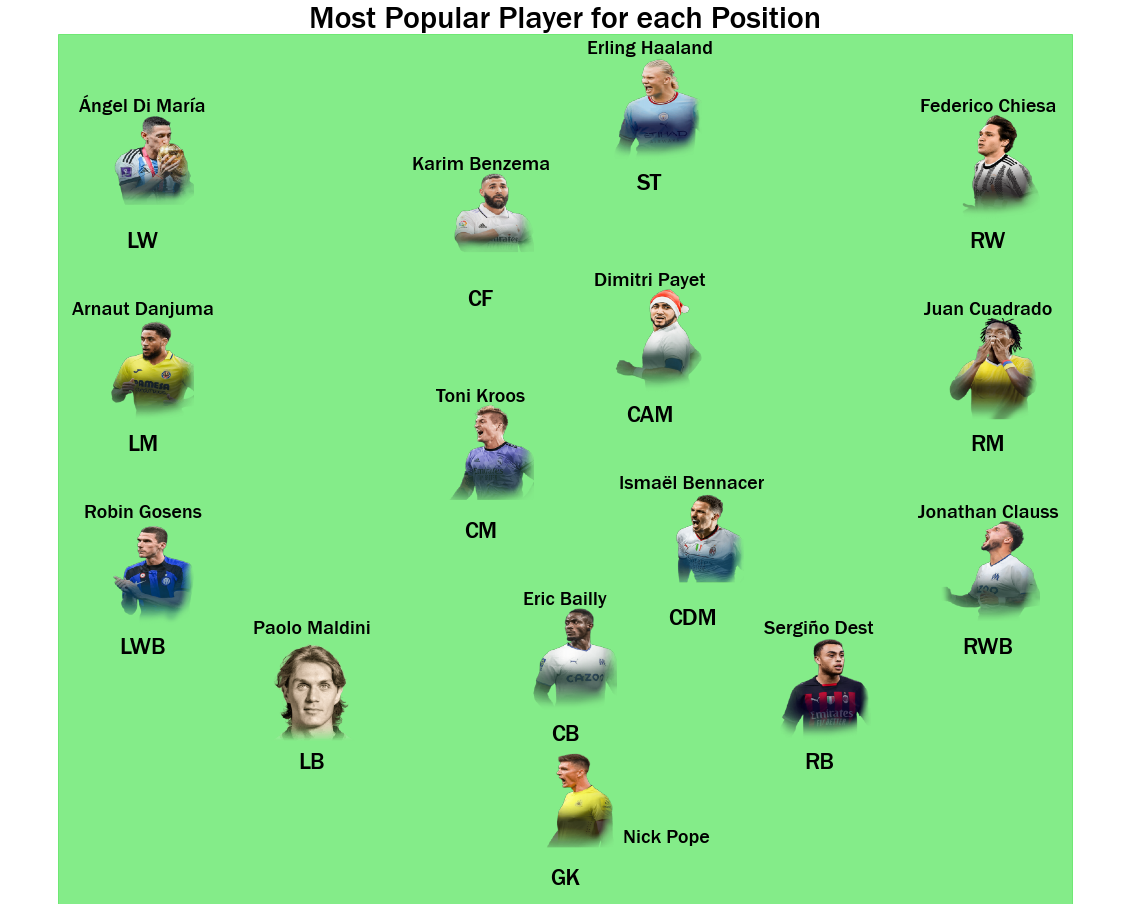

In [14]:
# -- Sleep for another Image Scraping -- #
sleep(30)

ax = make_field(False)

for index, row in popular_players.iterrows():
    x = row["X"]
    y = row["Y"]
    
    # Player Name
    if index == "GK":
        plt.text(s=row["Name"], x=x + 0.6, y=y, font=font, 
                 fontsize=20, ha="center", va="bottom")
    else:
        plt.text(s=row["Name"], x=x, y = y + 0.8, font=font, 
                 fontsize=20, ha="center", va="bottom")
    
    # Player Image
    sleep(5)
    imagebox = OffsetImage(get_player_image(row['Name']), zoom=0.65)
    ab = AnnotationBbox(imagebox, (x, y + 0.35), frameon=False)
    ax.add_artist(ab)

ax.set_title("Most Popular Player for each Position", font=font, fontsize=32)
plt.show()

<ul style="font-family:Inter;font-size:16px;padding:30px;border: 6px solid #69d071;border-radius:20px;line-height:30px">
    <li>The major part of these players are from <b>squad building challenges</b>, challenges by EA to give players with a lower price than the current ultimate team market. That's why they are popular, <b>the users take consideration the player price to upvote them.</b></li>
    <li><b>Benzema and Haaland</b> don't have a squad building challenge, that means they were liked because of their <b>great form in real life football.</b></li>
</ul>

<h2 style="font-family:Inter; font-size:24px">Position Analysis</h2>
<hr style="background-color:#498765; height:10px"></hr>
<p style="font-family:Inter; font-size:16px">Visualize attributes for each position.</p>

<div style="font-family:Inter;font-size:18px"><b style="background-color:#d8fde8; padding:5px">Processing:</b> Removing outliers, like nations with less than 10 players</div>

In [15]:
def group_by_column(column, minimum_count=10, agg="mean"):
    if agg=="mean":
        grouped = players_df.groupby(column).mean()
    elif agg=="sum":
        grouped = players_df.groupby(column).sum()
    elif agg=="max":
        grouped = players_df.groupby(column).max()
    else:
        grouped = players_df.groupby(column).min()
        
    counted = players_df.groupby(column).count()["Name"]
    grouped = grouped.join(counted)
    grouped.rename(columns={"Name": "Count"}, inplace=True)
    grouped = grouped.query("Count > %d" % minimum_count)
    
    return grouped

In [16]:
grouped_pos = group_by_column("Main_Position").reset_index()

<div style="font-family:Inter;font-size:18px"><b style="background-color:#d8fde8; padding:5px">Preparing the Dataset:</b> Set the values the right way to be read and with better visualization.</div>

In [17]:
columns = list(grouped_pos.columns[5:11])

pos_features = pd.melt(grouped_pos, id_vars="Main_Position", value_vars=columns, 
                       var_name="Feature", value_name="Avg_Feature")

In [18]:
# Creating a custom order
sort_dict = dict(zip(positions_coordinates.index, range(15)))

pos_features.sort_values("Main_Position", key=lambda x: x.map(sort_dict), inplace=True)

<div style="font-family:Inter;font-size:18px"><b style="background-color:#d8fde8; padding:5px">Visualization:</b> A Lineplot with an order of positions from defense to attack.</div>

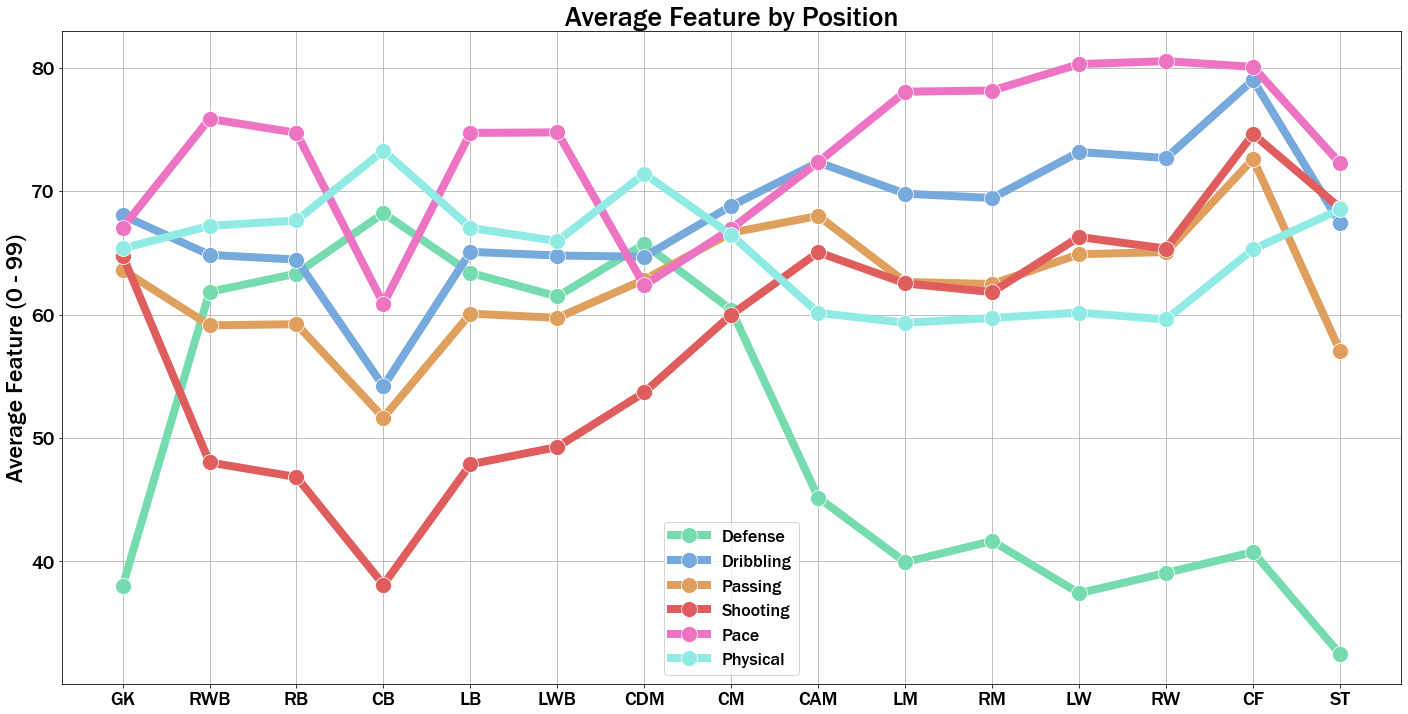

In [19]:
palette = ("#76dcb0", "#76a9dc", "#e0a05d", "#e05d5d", "#ed74c3", "#8febe4")

ax = sns.lineplot(data=pos_features, x="Main_Position", y="Avg_Feature", hue="Feature", 
                  palette=palette, lw=8, marker="o", markersize=16)
ax.figure.set_size_inches(24,12)
ax.set_title("Average Feature by Position", font=font, fontsize=28)
ax.set_xlabel("")
ax.set_ylabel("Average Feature (0 - 99)", font=font, fontsize=24)

plt.xticks(font=font, fontsize=20)
plt.yticks(font=font, fontsize=20)

# Legend and Grid
font_legend = fm.FontProperties(fname = './fonts/framd_m.ttf', size=18)
plt.legend(prop=font_legend, labels=["Defense", "Dribbling", "Passing", "Shooting", "Pace", "Physical"])
plt.grid(True)

plt.show()

<ul style="font-family:Inter;font-size:16px;padding:30px;border: 6px solid #69d071;border-radius:20px;line-height:30px">
<li> <b>Centerbacks (CB) have the highest average physical and defense</b> at the same time that have the <b>lowest shooting, dribbling, pace and passing</b> among all positions.</li>
<li><b>Center Midfielders</b> have the most <b>balanced</b> attributes.</li>
<li><b>Left and Right Wings</b> have the highest average pace, that is, <b>they are the fastest</b>.</li>
<li><b>Center Forwards have the most complete card for attacking</b>, having the highest average dribbling, passing and shooting, besides a high pace.</li>
<li>The defense lowers according the position gets more involved in attacking.</li>
</ul>

<h1 style="font-family:Inter;font-size:36px;background-color:#c4f2b3;padding:20px;border-radius:10px; text-align:center"> 
    What does the most expensive players have in common?</h1>

<div style="font-family:Inter;font-size:18px"><b style="background-color:#d8fde8; padding:5px">Let's analyze the top 50 most expensive players</b></div>

In [20]:
top_players = players_df.sort_values("Price", ascending=False).head(50)

<h2 style="font-family:Inter; font-size:24px">Where do they play?</h2>
<hr style="background-color:#498765; height:10px"></hr>
<p id="where-they-play" style="font-family:Inter; font-size:16px">Taking into consideration nation and club. But firstly, there is an example of how the function of scraping the club badge image works.</p>

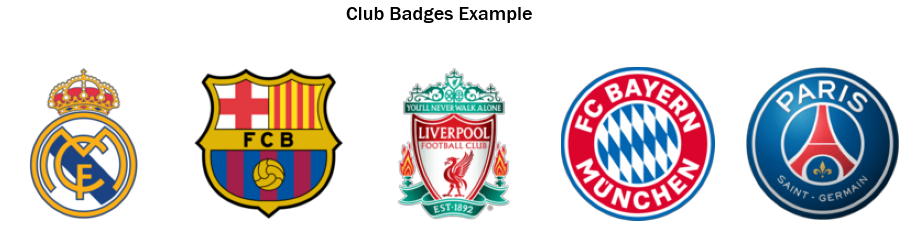

In [21]:
example = ["Real Madrid", "FC Barcelona", "Liverpool", "FC Bayern", "Paris SG"]
plt.figure(figsize=(16, 4))

for j, ex in enumerate(example):
    plt.subplot(1, 5, j + 1)
    plt.imshow(get_club_image(ex))
    plt.axis("off")

plt.suptitle("Club Badges Example", font=font, fontsize=20)
plt.show()

In [22]:
clubs = top_players.groupby("Club").count()[["Name"]].sort_values("Name", ascending=False).reset_index()
nations = top_players.groupby("Nation").count()[["Name"]].sort_values("Name", ascending=False).reset_index()

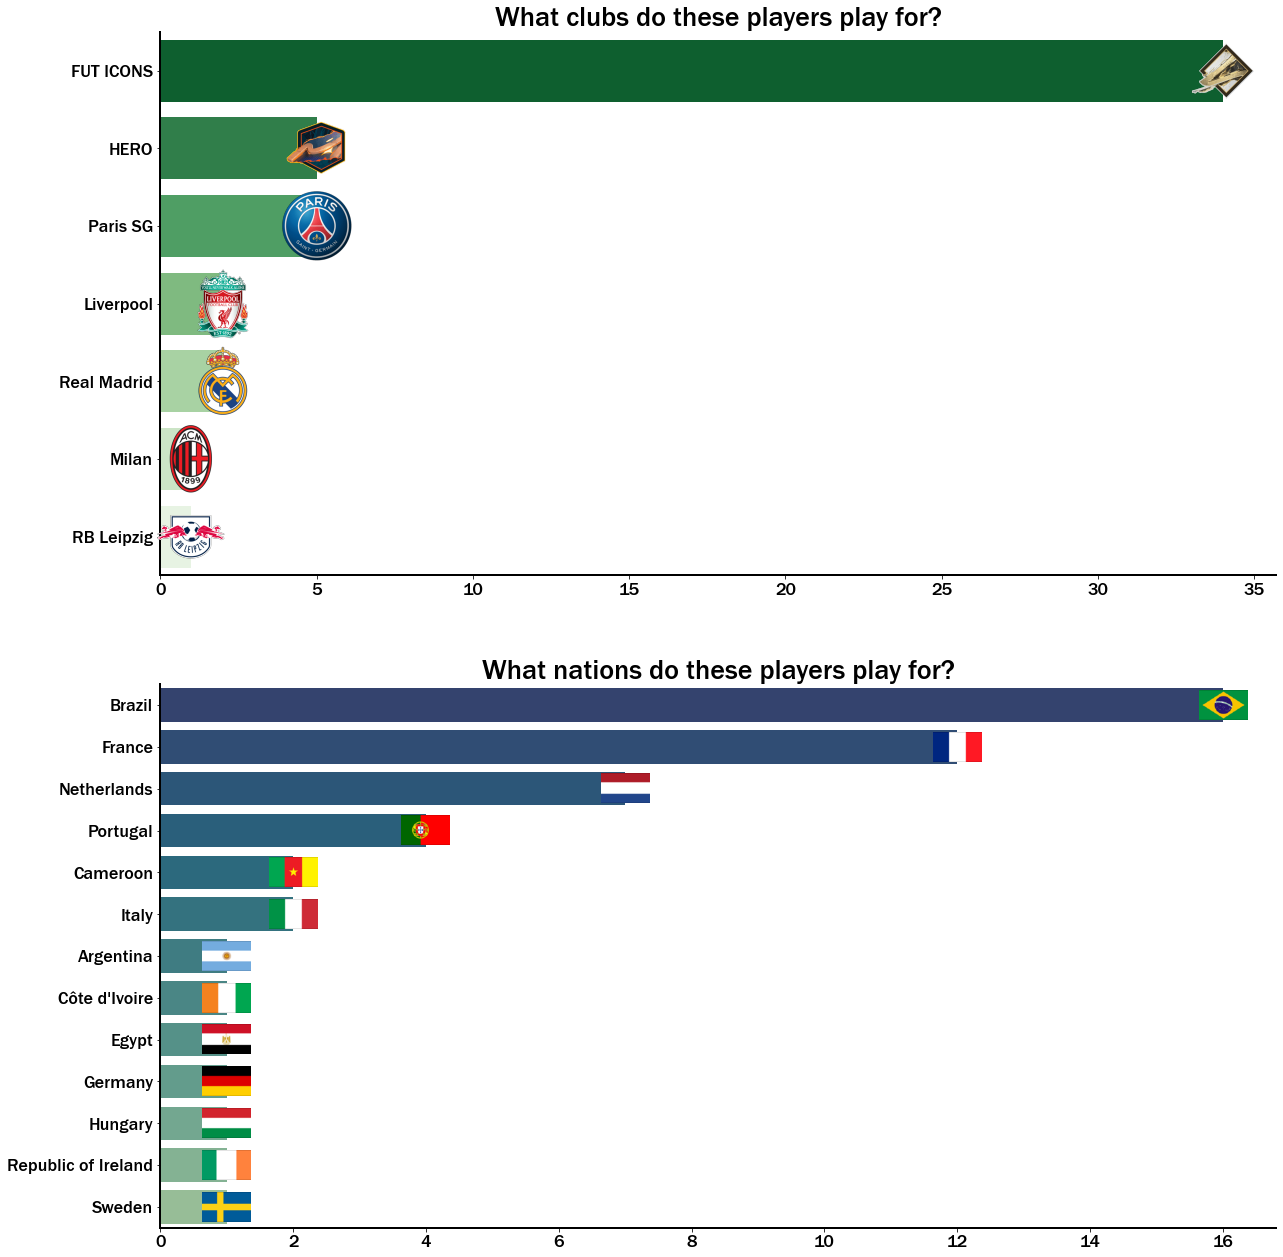

In [23]:
sleep(20)
dataframes = (clubs, nations)
palette = ("Greens_r", "crest_r")
titles = ("What clubs do these players play for?", "What nations do these players play for?")
fig = plt.figure(figsize=(20, 22))

for i, df in enumerate(dataframes):
    plt.subplot(2, 1, i + 1)
    col = "Nation" if i else "Club"
    ax = sns.barplot(y=df[col], x=df["Name"], palette=palette[i])
    
    # -- Graph Format -- #
    ax.set_title(titles[i], font=font, fontsize=28)
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_xticklabels([round(tick) for tick in ax.get_xticks()], font=font, fontsize=18)
    ax.set_yticklabels(ax.get_yticklabels(), font=font, fontsize=18)
    ax.spines['left'].set(lw=2)
    ax.spines['bottom'].set(lw=2)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # -- Get the flags and club badges -- #
    sleep(5)
    if i:
        img = [get_nation_image(nation) for nation in df['Nation']]
    else:
        img = [get_club_image(club) for club in df['Club']]

    # -- Adding the Flags -- #
    for index, row in df.iterrows():
        # Add the flags
        zoom = 0.7 if i else 0.5
        imagebox = OffsetImage(img[index], zoom=zoom)
        ab = AnnotationBbox(imagebox, (row["Name"], index), frameon=False)
        ax.add_artist(ab)
        
plt.show()

<ul style="font-family:Inter;font-size:16px;padding:30px;border: 6px solid #69d071;border-radius:20px;line-height:30px">
    <li> <b>Icons</b> dominate the list with <b>34 players</b>. The real club with most players among the 50 most expensive players is <b>Paris Saint Germain</b> with <b>Mbappé, Neymar and Messi</b> and their card versions.</li>
    <li>The nations with the most players in the top 50 most expensive list are <b>Brazil, France and Netherlands</b>, with 35 players together. This fact is consequence of the dominance of the icons, and these three nations have a lot of legendary players that are also good in game.</li>
</ul>

<h2 style="font-family:Inter; font-size:24px">Position, Weak Foot, Skills and Run Style</h2>
<hr style="background-color:#498765; height:10px"></hr>
<p id="po_wf_sk_rs" style="font-family:Inter; font-size:16px">How many players of these list of the most expensive plays in attacking positions, how many are skillful or have a great ball control with both feet and how they run. Let's see if they have something in common in these game features.</p>

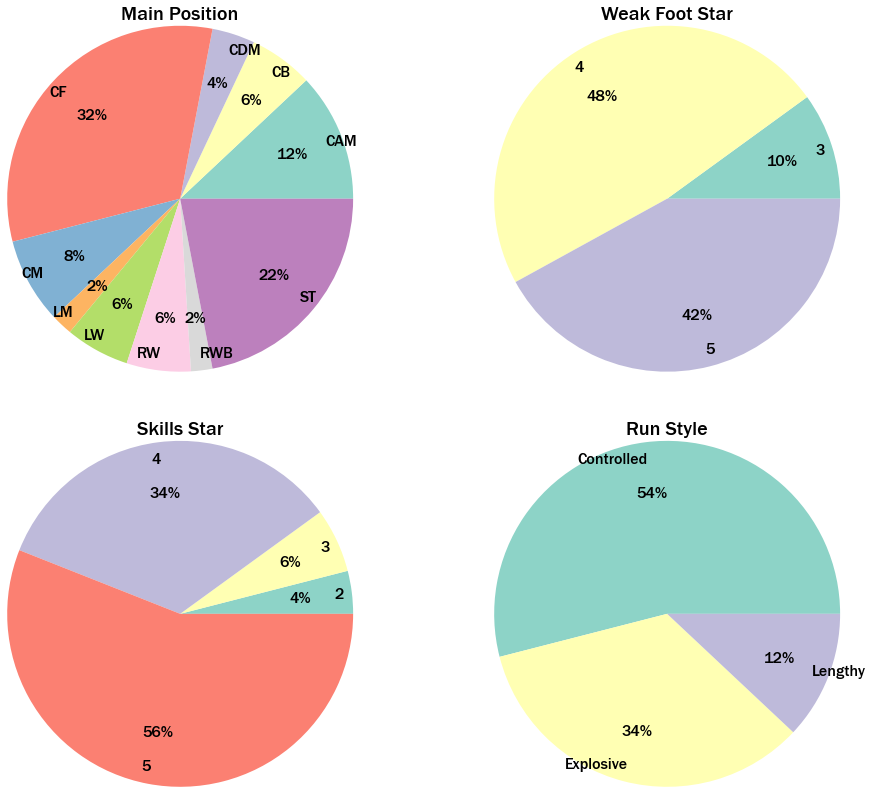

In [24]:
features = ("Main_Position", "Weak_Foot_Star", "Skills_Star", "Run_Style")
palette = sns.color_palette("Set3")

fig = plt.figure(figsize=(16, 14))
for e, ft in enumerate(features):
    ax = plt.subplot(2, 2, e + 1)
    df = top_players.groupby(ft).count()[["Name"]]
    ax.pie(x=df["Name"], labels=df.index, autopct="%.0f%%", 
           radius=1.25, labeldistance=0.9, pctdistance=0.7, 
           textprops=dict(fontsize=16, font=font), colors=palette)
    ax.set_title(ft.replace("_", " "), font=font, fontsize=20)
    
plt.show()

<ul style="font-family:Inter;font-size:16px;padding:30px;border: 6px solid #69d071;border-radius:20px;line-height:30px">
<li><b>The major part of them have an attacking role</b>, the exceptions are the CDM, CB and RWB positions.</li>
<li>90% of players has over 4 stars of weak foot or over 4 stars skills, meaning the features of <b>skillfulness</b> and being able to <b>control the ball with both feet</b> are extremely important.</li>
<li>Also, 44 out of 50 players has a controlled or explosive running style, these style are normally from fast players, while Lenghty is assigned to slow and strong players. <b>That is, being fast is important to increase a player price</b>.</li>
<li><b>Center Forward (CF)</b> is the position with the most expensive players.</li>
</ul>

<h2 style="font-family:Inter; font-size:24px">Attributes</h2>
<hr style="background-color:#498765; height:10px"></hr>
<p style="font-family:Inter; font-size:16px">The attributes in the face card - Pace, Shooting, Passing, Dribbling, Defense and Physical.</p>

In [25]:
attributes = list(top_players.columns[15:21])
att_data = top_players[attributes].mean()
att_data.index = [att.split(" / ")[0] for att in attributes]

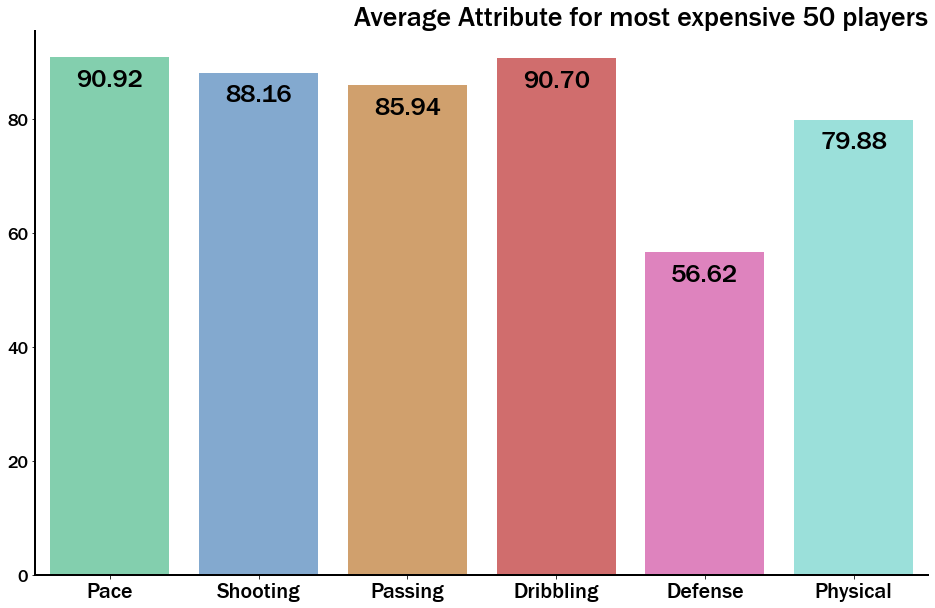

In [26]:
palette = ("#76dcb0", "#76a9dc", "#e0a05d", "#e05d5d", "#ed74c3", "#8febe4")

ax = sns.barplot(x=att_data.index, y=att_data, palette=palette)
ax.figure.set_size_inches(16, 10)
ax.set_title("Average Attribute for most expensive 50 players", 
             font=font, fontsize=28, loc="right")
ax.set_ylabel("")
ax.set_xlabel("")
plt.yticks(font=font, fontsize=18)
plt.xticks(font=font, fontsize=22)
ax.spines['left'].set(lw=2)
ax.spines['bottom'].set(lw=2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for index, value in enumerate(att_data):
    plt.text(s="%.2f" % value, x=index, y= value - 5, 
             font=font, fontsize=26, ha="center")

plt.show()

<ul style="font-family:Inter;font-size:16px;padding:30px;border: 6px solid #69d071;border-radius:20px;line-height:30px">
<li>Every <b>attacking attribute is over 85</b> and relatively <b>low defense</b>, since most players of the top 50 most expensive players list have an attacking role.</li>
<li><b>Pace and Dribbling are above 90</b>, reinforcing the thesis of how <b>speed and skillfulness influence the players price.</b></li>
</ul>

<h1 style="font-family:Inter;font-size:36px;text-align:center;background-color:#c4f2b3;padding:20px;border-radius:10px"> 
    Analyzing the Nation </h1>

<div style="font-family:Inter;font-size:18px"><b style="background-color:#d8fde8; padding:5px">Let's group the nations and analyze them</b>. But firstly, there's a example of usage of the function to show the nation flag.</div>

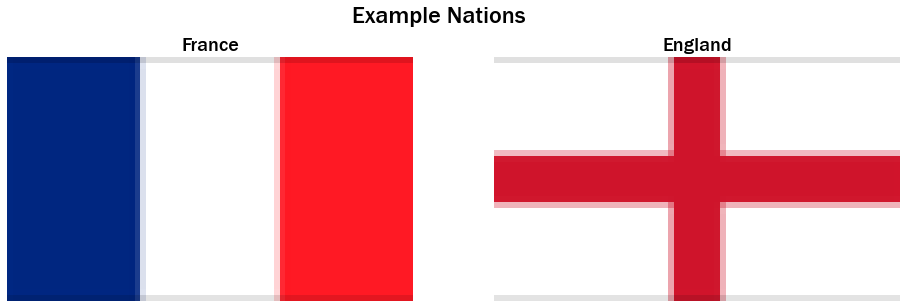

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))
examples = ("France", "England")

for j in range(2):
    ax[j].imshow(get_nation_image(examples[j]))
    ax[j].axis("off")
    ax[j].set_title(examples[j], font=font, fontsize=20)
    
plt.suptitle("Example Nations", font=font, fontsize=24)
plt.show()

<h2 style="font-family:Inter; font-size:24px">Price and Rating</h2>
<hr style="background-color:#498765; height:10px"></hr>
<p style="font-family:Inter; font-size:16px">Take the average price and rating for each nation, dropping nations with less than 10 players to improve the result removing outliers.</p>

In [28]:
grouped_nation = group_by_column("Nation")
grouped_nation.head()

,Rating,Price,Skills_Star,Weak_Foot_Star,Pace / Diving,Shooting / Handling,Passing / Kicking,Dribbling / Reflexes,Defense / Speed,Physical / Positioning,Popularity,Base_Stats,Ingame_Stats,Count
Nation,,,,,,,,,,,,,,
Albania,68.173913,591.304348,2.043478,2.956522,68.260870,55.760870,57.978261,64.108696,52.934783,68.217391,2.869565,367.260870,1651.173913,46
Algeria,72.309091,8461.818182,2.454545,3.036364,71.309091,62.945455,66.963636,72.054545,51.963636,67.909091,231.345455,393.145455,1751.509091,55
Angola,69.437500,562.500000,3.062500,3.000000,79.312500,60.062500,61.375000,69.687500,45.500000,62.687500,4.937500,378.625000,1770.437500,16
Argentina,71.389474,11183.099415,2.251462,2.956725,70.066667,59.815205,63.748538,68.773099,54.308772,68.728655,85.343860,385.440936,1722.935673,855
Australia,65.429043,2028.547855,1.745875,3.049505,69.686469,52.867987,57.679868,62.660066,50.900990,67.656766,10.874587,361.452145,1580.940594,303


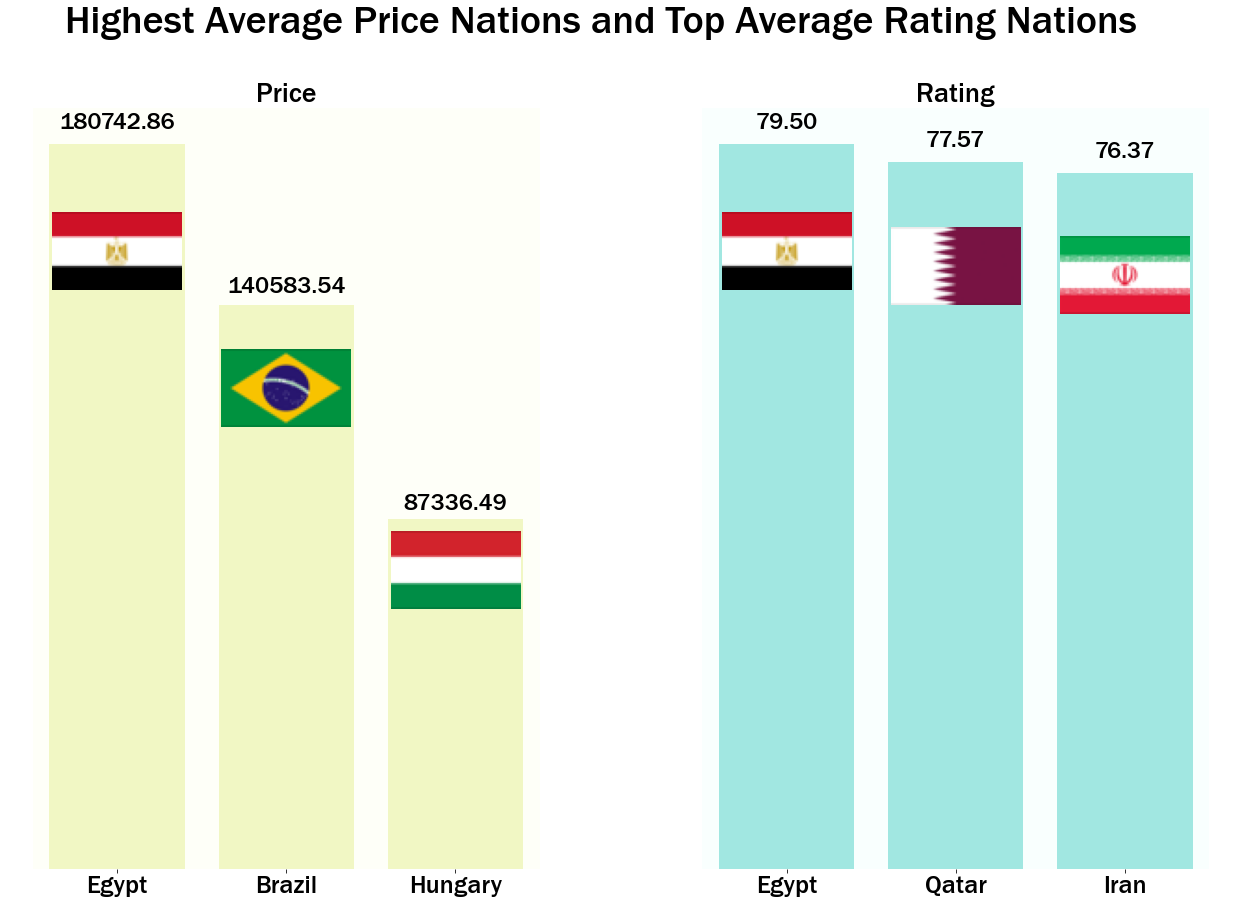

In [29]:
features = ("Price", "Rating")
palette = ("#f7ffb9", "#8af0e8")
background = ("#f9ffd0", "#ddfffc")
fig = plt.figure(figsize=(22, 14))

for i, feature in enumerate(features):
    #  -- DataFrame ordered by the feature -- #
    df = grouped_nation.sort_values(feature, ascending=False).reset_index().head(3)
    
    # -- Graph and setting -- #
    plt.subplot(1, 2, i + 1)
    ax = sns.barplot(data=df, x = "Nation", y = feature, color=palette[i])
    ax.set_title(feature, fontsize=28, font=font)
    ax.set_ylabel("")
    ax.set_xlabel("")
    plt.yticks([])
    plt.xticks(font=font, fontsize=26)
    
    ## Hiding the spines
    [spine.set_visible(False) for spine in ax.spines.values()]
    
    # Get the flags
    img = [get_nation_image(nation) for nation in df['Nation']]
    
    # -- Adding the Flags -- #
    for index, row in df.iterrows():
        x = int(index)
        y = float(row[feature]) * 1.015
        text = "%.2f" % float(row[feature])
        plt.text(s=text, y=y, x=x, font=font, 
                 fontsize=24, ha="center", va="bottom")
        
        # Add the flags
        imagebox = OffsetImage(img[index], zoom=1.85)
        ab = AnnotationBbox(imagebox, (x, y * 0.84), frameon=False)
        ax.add_artist(ab)
        
    # -- Adding the background -- #
    ax.axvspan(fc=background[i], xmin=-0.5, xmax=2.5, alpha=0.15)
    
    
plt.suptitle("Highest Average Price Nations and Top Average Rating Nations", 
             fontsize=40, font=font)


plt.show()

<ul style="font-family:Inter;font-size:16px;padding:30px;border: 6px solid #69d071;border-radius:20px;line-height:30px">
    <li><b>Egypt</b> has the highest average player price and rating, reinforcing the statement of <b>having few players but very popular and expensive in game</b>.</li>
    <li><b>Brazil</b> have a lot players in game and still have a high average price, <b>affirming their popularity in football.</b></li>
</ul>

<h2 style="font-family:Inter; font-size:24px">Attributes per Nation</h2>
<hr style="background-color:#498765; height:10px"></hr>
<p style="font-family:Inter; font-size:16px">The average attribute for each nation, and see what got the highest and lowest.</p>

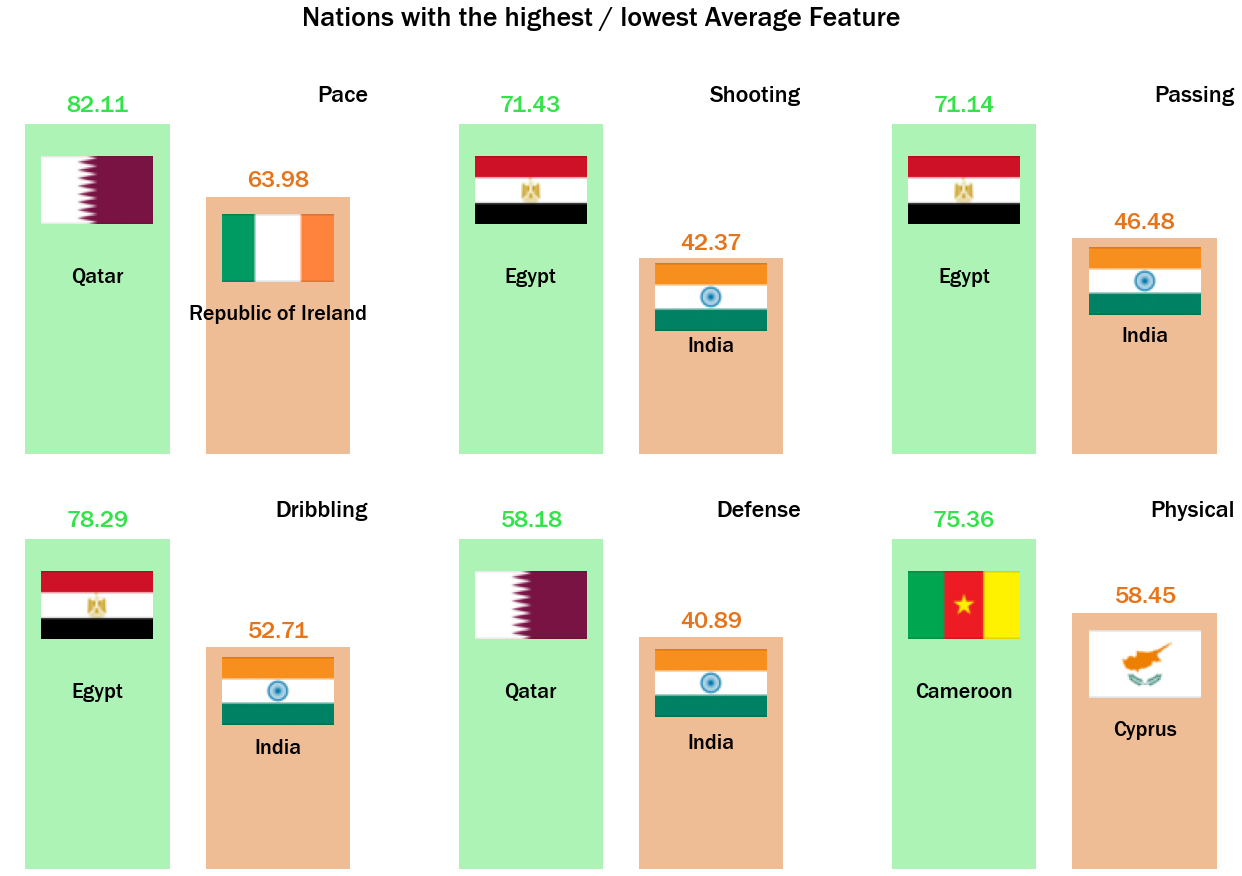

In [30]:
fig = plt.figure(figsize=(22, 14))
palette = ("#89ff98", "#ffab68")
text = ("#34e24a", "#e5741b")
columns = list(grouped_nation.columns[4:10])

for e, feature in enumerate(columns):
    # -- Dataframe for Feature -- #
    df = grouped_nation.sort_values(feature, ascending=False).reset_index()
    highest_lowest = pd.concat([df.head(1), df.tail(1)]).reset_index()
    
    # -- Plotting -- #
    plt.subplot(2, 3, e + 1)
    ax = sns.barplot(data=highest_lowest, x = "Nation", 
                     y = feature, palette=palette, alpha=0.8)
    ax.axis("off")
    ax.set_title(feature.split(" / ")[0], font=font, fontsize=24, loc="right")
        
    # Flags
    img = [get_nation_image(nation) for nation in highest_lowest['Nation']]
    
    # -- Adding Details -- #
    for index, row in highest_lowest.iterrows():
        y = row[feature]
        # Feature
        plt.text(s="%.2f" % y, x=index, y = y * 1.025, color=text[index],
                 font=font, fontsize=24, ha="center", va="bottom")
        
        # Nation Name
        plt.text(s=row["Nation"], x=index, y = y * 0.52, font=font,
                 fontsize=22, ha="center")        
        
        # Flag
        imagebox = OffsetImage(img[index], zoom=1.6)
        ab = AnnotationBbox(imagebox, (index, y * 0.8), frameon=False)
        ax.add_artist(ab)
    
plt.suptitle("Nations with the highest / lowest Average Feature", font=font, fontsize=28)
plt.show()

<ul style="font-family:Inter;font-size:16px;padding:30px;border: 6px solid #69d071;border-radius:20px;line-height:30px">
    <li><b>India</b> has the lowest average feature in 4 out of 6 features, meaning that the nation has <b>a lot of low rating players in the game</b>.</li>
    <li><b>Egypt and Qatar have the highest average feature in 5 out of 6 attributes</b>. That's because they have <b>few players</b> and these few players have a great overall and stats, increasing the mean.</li>
    <li>Popular nations like <b>Brazil, France and Netherlands</b> - see below - don't appear in that list, they have excellent players at the same time as have low rating players from lower national division leagues. </li>
</ul>

<h2 style="font-family:Inter; font-size:24px">What are the most popular nations in Ultimate Team?</h2>
<hr style="background-color:#498765; height:10px"></hr>
<p style="font-family:Inter; font-size:16px">Let's take into consideration how many players a nation has and the average like / dislike balance for nation.</p>

In [31]:
grouped_nation_sum = group_by_column("Nation", agg="sum", minimum_count=0)
grouped_nation_sum.sort_values("Popularity", ascending=False, inplace=True)
grouped_nation_sum["Binary_Popularity"] = grouped_nation_sum["Popularity"].apply(lambda x: "Negative" if x < 0 else "Positive")

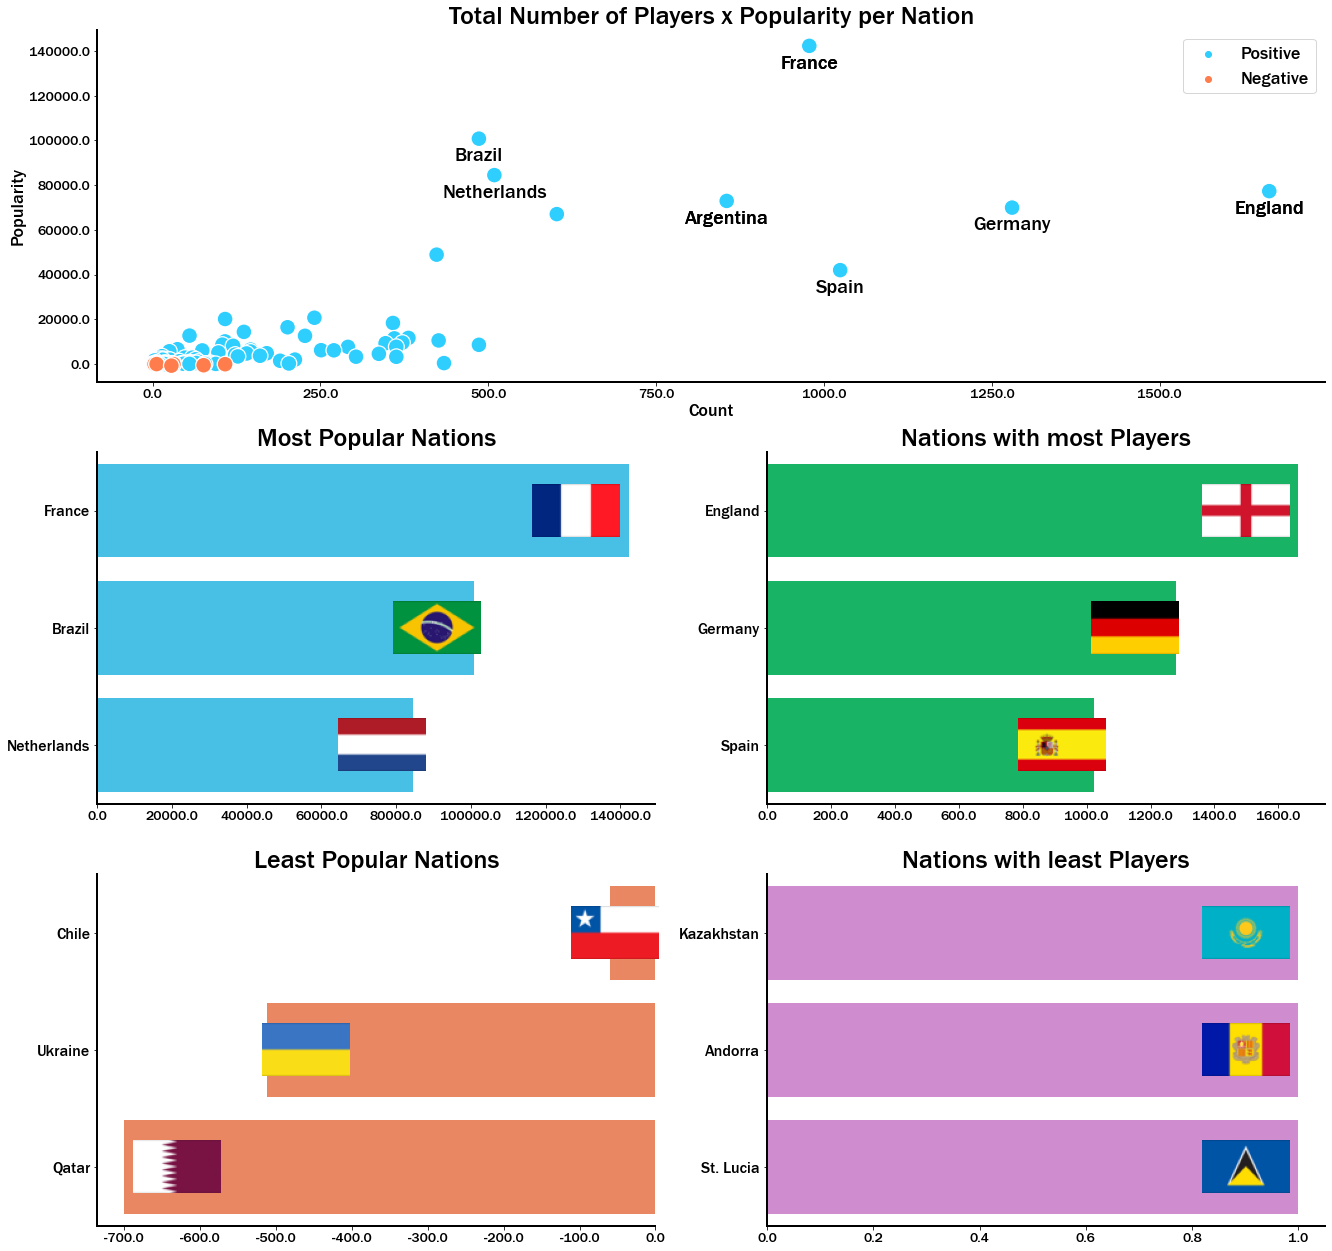

In [32]:
# -- Figure Configuration -- #
fig = plt.figure(figsize=(22, 22))
ax1 = fig.add_subplot(3, 2, 3)
ax2 = fig.add_subplot(3, 2, 4)
ax3 = fig.add_subplot(3, 2, 5)
ax4 = fig.add_subplot(3, 2, 6)
ax0 = fig.add_subplot(3, 1, 1)
axes_list = [ax0, ax1, ax2, ax3, ax4]

# -- Presets -- #
sort_count = grouped_nation_sum.sort_values("Count", ascending=False).reset_index()
dataframes = [grouped_nation_sum.head(3).reset_index(), sort_count.head(3).reset_index(), 
              grouped_nation_sum.tail(3).reset_index(), sort_count.tail(3).reset_index()]
titles = ["Total Number of Players x Popularity per Nation", "Most Popular Nations", 
          "Nations with most Players", "Least Popular Nations", "Nations with least Players"]
palette = ["#2eceff", "#ff7d4c"]
palette_2 = ["#00cc66", "#da82da"]

# -- Scatter -- #
sns.scatterplot(ax=ax0, data=grouped_nation_sum, x = "Count", y = "Popularity", s=250, 
                     hue="Binary_Popularity", palette=palette)
nations_with_most_count = grouped_nation_sum.sort_values("Count").tail(5)

for index, row in nations_with_most_count.iterrows():
    ax0.text(s=index, x=row["Count"], y=row["Popularity"] - 10e3, 
             ha="center", font=font, fontsize=20)
for index, row in grouped_nation_sum.head(5).iterrows():
    ax0.text(s=index, x=row["Count"], y=row["Popularity"] - 10e3, 
             ha="center", font=font, fontsize=20)

ax0.set_ylabel("Popularity", font=font, fontsize=18)
ax0.set_xlabel("Count", font=font, fontsize=18)
ax0.set_yticklabels(ax0.get_yticks(), font=font, fontsize=14)
ax0.legend(prop=font_legend)

# -- Most and Least Popular -- #
# Most Bar
sns.barplot(ax=ax1, data=dataframes[0], 
            y="Nation", x="Popularity", dodge=False, color=palette[0])
# Least Bar
sns.barplot(ax=ax3, data=dataframes[2], 
            y="Nation", x="Popularity", dodge=False, color=palette[1])

# -- Count Nations -- #
# Most Appereance
sns.barplot(ax=ax2, data=dataframes[1], 
            y="Nation", x="Count", dodge=False, color=palette_2[0])
# Least Appearence
sns.barplot(ax=ax4, data=dataframes[3], 
            y="Nation", x="Count", dodge=False, color=palette_2[1])

# -- Geral Configuration -- #
for i, axis in enumerate(axes_list):
    axis.spines['left'].set(lw=2)
    axis.spines['bottom'].set(lw=2)
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)
    axis.set_title(titles[i], font=font, fontsize=26)
    axis.set_xticklabels([j.round(1) for j in axis.get_xticks()], font=font, fontsize=14)
    
# -- Small Plots Configuration -- #
for e, s_axis in enumerate(axes_list[1:]):
    s_axis.set_ylabel("")
    s_axis.set_xlabel("")
    s_axis.set_yticklabels(s_axis.get_yticklabels(), font=font, fontsize=16)
    
    # Plotting the flags
    img_nations = [get_nation_image(nation) for nation in dataframes[e]["Nation"]]
    col = "Popularity" if e % 2 == 0 else "Count" 
    for index, row in dataframes[e].iterrows():
        imagebox = OffsetImage(img_nations[index], zoom=1.25)
        x_pos = row[col] * 0.9
        ab = AnnotationBbox(imagebox, (x_pos, index), frameon=False)
        s_axis.add_artist(ab)


plt.show()

<ul style="font-family:Inter;font-size:16px;padding:30px;border: 6px solid #69d071;border-radius:20px;line-height:30px">
    <li><b>European nations</b> dominate the popularity list and have the most number of players in the game, <b>Brazil and Argentina</b> also make it there.</li>
<li>Qatar is the most disliked nation in ultimate team in reason of not having popular players in game and in real life.</li>
<li>There are nations with only one player in ultimate team, these countries are small or have other sports in their culture.</li>
</ul>

<h1 style="font-family:Inter;font-size:36px;text-align:center;background-color:#c4f2b3;padding:20px;border-radius:10px"> 
    Analyzing the Clubs </h1>

<div style="font-family:Inter;font-size:18px"><b style="background-color:#d8fde8; padding:5px">Let's group the clubs and analyzing them</b>. The analysis is similar to the nation analysis.</div>

In [33]:
grouped_club = group_by_column("Club")
grouped_club.head()

,Rating,Price,Skills_Star,Weak_Foot_Star,Pace / Diving,Shooting / Handling,Passing / Kicking,Dribbling / Reflexes,Defense / Speed,Physical / Positioning,Popularity,Base_Stats,Ingame_Stats,Count
Club,,,,,,,,,,,,,,
1. FC Heidenheim,66.035714,503.571429,1.464286,2.928571,68.250000,54.571429,58.214286,63.357143,51.964286,67.428571,28.714286,363.785714,1595.071429,28
1. FC Köln,70.517241,975.862069,2.172414,2.965517,68.275862,59.655172,61.965517,67.620690,52.655172,68.620690,15.517241,378.793103,1649.379310,29
1. FC Magdeburg,64.344828,400.000000,1.862069,3.034483,68.827586,51.482759,56.758621,62.275862,49.103448,61.931034,2.862069,350.379310,1537.689655,29
1. FC Nürnberg,65.931034,663.793103,1.724138,3.034483,67.000000,53.586207,58.241379,63.862069,49.482759,63.724138,4.793103,355.896552,1578.241379,29
1. FSV Mainz 05,70.931034,582.758621,2.206897,3.206897,70.172414,59.344828,63.310345,69.172414,57.172414,69.241379,10.586207,388.413793,1712.137931,29


<h2 style="font-family:Inter; font-size:24px">Price and Rating</h2>
<hr style="background-color:#498765; height:10px"></hr>
<p style="font-family:Inter; font-size:16px">Take the average price and rating for each club.</p>
<p style="font-family:Inter; font-size:16px"><b style="background-color:#d8fde8; padding:5px">I removed League Heroes Club and Fut Icons club:</b> they change the result because how good and expensive their players are and aren't clubs in real life.</p>
<p style="font-family:Inter; font-size:16px"><b style="background-color:#d8fde8; padding:5px">I also removed nations from World Cup:</b> during world cup, FIFA 23 launched players from world cup mode, where their club are their nation. This could interfere in the result.</p>

In [34]:
grouped_club.drop(["FUT ICONS", "HERO"], inplace=True)

In [35]:
nations_list = grouped_nation.index
grouped_club.drop(nations_list, errors="ignore", inplace=True)

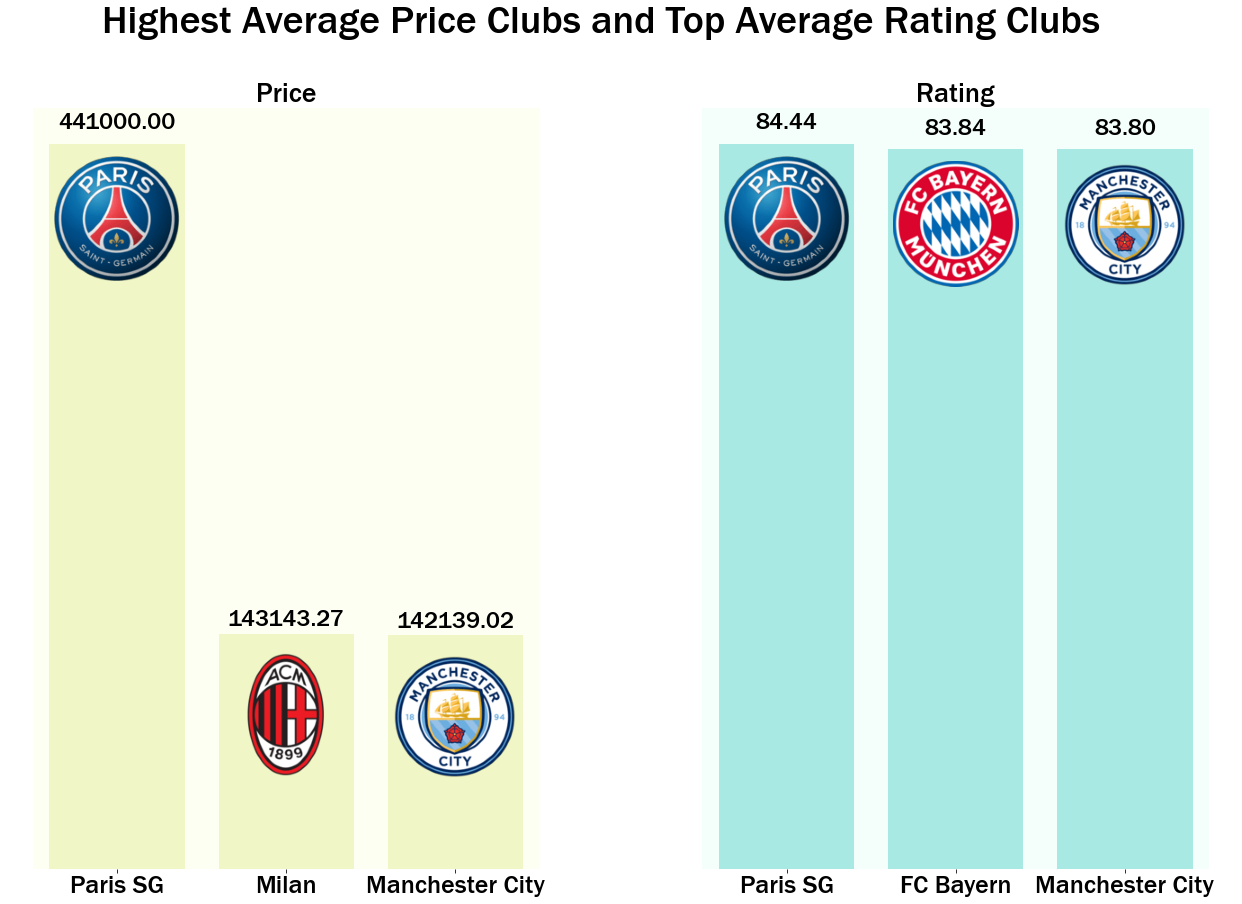

In [36]:
features = ("Price", "Rating")
palette = ("#f7ffb9", "#8af0e8")
background = ("#f9ffd0", "#ddfffc")
fig = plt.figure(figsize=(22, 14))

for i, feature in enumerate(features):
    #  -- DataFrame ordered by the feature -- #
    df = grouped_club.sort_values(feature, ascending=False).reset_index().head(3)
    
    # -- Graph and setting -- #
    plt.subplot(1, 2, i + 1)
    ax = sns.barplot(data=df, x = "Club", y = feature, 
                     color=palette[i])
    ax.set_title(feature, fontsize=28, font=font)
    ax.set_ylabel("")
    ax.set_xlabel("")
    plt.yticks([])
    plt.xticks(font=font, fontsize=26)
    
    ## Hiding the spines
    [spine.set_visible(False) for spine in ax.spines.values()]
    
    # Get the flags
    img = [get_club_image(club) for club in df["Club"]]
    
    # -- Adding the Flags -- #
    for index, row in df.iterrows():
        x = int(index)
        y = float(row[feature]) * 1.015
        text = "%.2f" % float(row[feature])
        plt.text(s=text, y=y, x=x, font=font, 
                 fontsize=24, ha="center", va="bottom")
        
        # Add the flags
        imagebox = OffsetImage(img[index], zoom=0.9)
        y_diff =  10 if i else 5.2e4
        ab = AnnotationBbox(imagebox, (x, y - y_diff), frameon=False)
        ax.add_artist(ab)
        
        # -- Adding the background -- #
        ax.axvspan(fc=background[i], xmin=-0.5, xmax=2.5, alpha=0.1)
    
plt.suptitle("Highest Average Price Clubs and Top Average Rating Clubs", 
             fontsize=40, font=font)


plt.show()

<ul style="font-family:Inter;font-size:16px;padding:30px;border: 6px solid #69d071;border-radius:20px;line-height:30px">
    <li><b>Paris Saint Germain</b> has the highest average player price in ultimate team market by far at the same time that has the highest average rating. That's because <b>the club has a lot of good players, like Mbappé, Messi and Neymar</b> with their card versions and <b>figures out in the top 50 most expensive players with 5 cards</b> as showed <a href="#where-they-play">here</a>.</li>
    <li><b>Manchester City and Bayern are consistent</b> with their players, maiteining the average rating high.</li>
    <li><b>Milan</b> has a great average player price because <b>they have one player among the top 50 most expensive players.</b></li>
</ul>

<h2 style="font-family:Inter; font-size:24px">Club Popularity</h2>
<hr style="background-color:#498765; height:10px"></hr>
<p style="font-family:Inter; font-size:16px">A set of graphs showing if the number of players interfere in the popularity of the club, while showing the most popular clubs - similar to the nations set of graphs.</p>

In [37]:
grouped_club_sum = group_by_column("Club", agg="sum", minimum_count=0)
grouped_club_sum.sort_values("Popularity", ascending=False, inplace=True)
grouped_club_sum["Binary_Popularity"] = grouped_club_sum["Popularity"]\
                                            .apply(lambda x: "Negative" if x < 0 else "Positive")

# Dropping Nations, Icon and Hero
grouped_club_sum.drop(["FUT ICONS", "HERO"], inplace=True)
grouped_club_sum.drop(nations_list, errors="ignore", inplace=True)

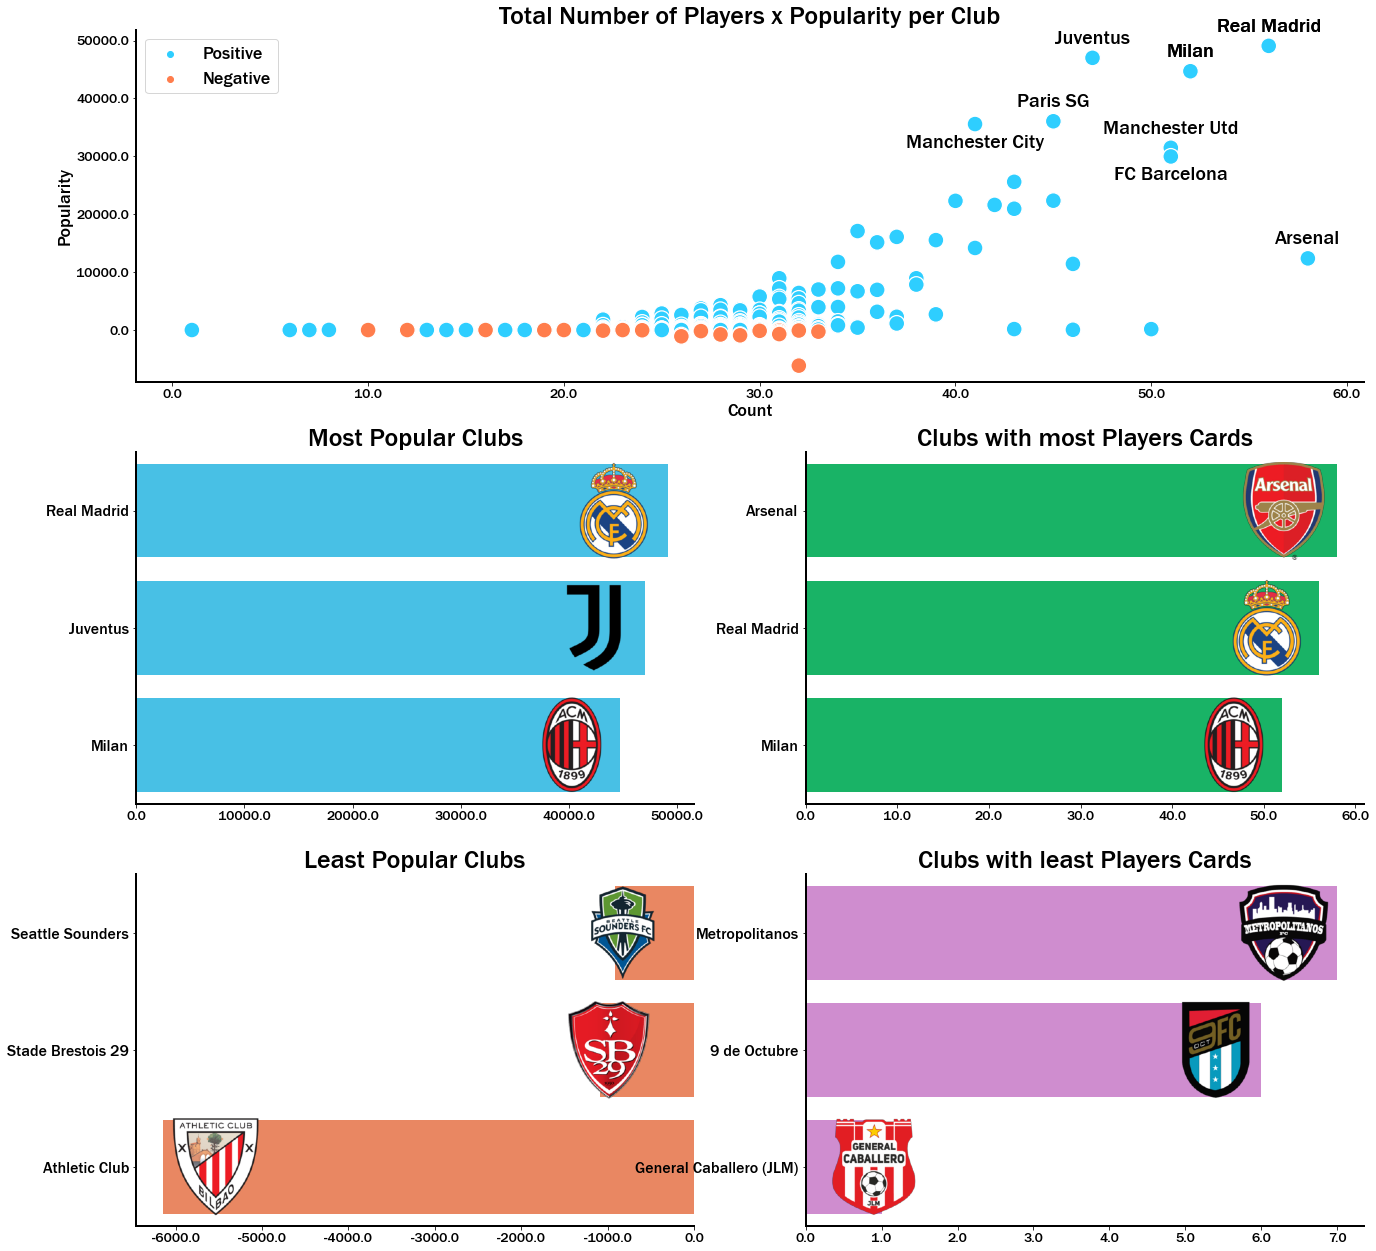

In [38]:
sleep(15)
# -- Figure Configuration -- #
fig = plt.figure(figsize=(22, 22))
ax1 = fig.add_subplot(3, 2, 3)
ax2 = fig.add_subplot(3, 2, 4)
ax3 = fig.add_subplot(3, 2, 5)
ax4 = fig.add_subplot(3, 2, 6)
ax0 = fig.add_subplot(3, 1, 1)
axes_list = [ax0, ax1, ax2, ax3, ax4]

# -- Presets -- #
sort_count = grouped_club_sum.sort_values("Count", ascending=False).reset_index()
dataframes = [grouped_club_sum.head(3).reset_index(), sort_count.head(3).reset_index(), 
              grouped_club_sum.tail(3).reset_index(), sort_count.tail(3).reset_index()]
titles = ["Total Number of Players x Popularity per Club", "Most Popular Clubs", 
          "Clubs with most Players Cards", "Least Popular Clubs", "Clubs with least Players Cards"]
palette = ["#2eceff", "#ff7d4c"]
palette_2 = ["#00cc66", "#da82da"]

# -- Scatter -- #
sns.scatterplot(ax=ax0, data=grouped_club_sum, x = "Count", y = "Popularity", s=250, 
                     hue="Binary_Popularity", palette=palette)
clubs_with_most_count = grouped_club_sum.sort_values("Count").tail(5)

for index, row in clubs_with_most_count.iterrows():
    y_diff = -4e3 if index in ["Manchester City", "FC Barcelona"] else 2.5e3
    ax0.text(s=index, x=row["Count"], y=row["Popularity"] + y_diff, 
             ha="center", font=font, fontsize=20)
for index, row in grouped_club_sum.head(5).iterrows():
    y_diff = -4e3 if index in ["Manchester City", "FC Barcelona"] else 2.5e3
    ax0.text(s=index, x=row["Count"], y=row["Popularity"] + y_diff, 
             ha="center", font=font, fontsize=20)

ax0.set_ylabel("Popularity", font=font, fontsize=18)
ax0.set_xlabel("Count", font=font, fontsize=18)
ax0.set_yticklabels(ax0.get_yticks(), font=font, fontsize=14)
ax0.legend(prop=font_legend)

# -- Most and Least Popular -- #
# Most Bar
sns.barplot(ax=ax1, data=dataframes[0], 
            y="Club", x="Popularity", dodge=False, color=palette[0])
# Least Bar
sns.barplot(ax=ax3, data=dataframes[2], 
            y="Club", x="Popularity", dodge=False, color=palette[1])

# -- Count Nations -- #
# Most Appereance
sns.barplot(ax=ax2, data=dataframes[1], 
            y="Club", x="Count", dodge=False, color=palette_2[0])
# Least Appearence
sns.barplot(ax=ax4, data=dataframes[3], 
            y="Club", x="Count", dodge=False, color=palette_2[1])

# -- Geral Configuration -- #
for i, axis in enumerate(axes_list):
    axis.spines['left'].set(lw=2)
    axis.spines['bottom'].set(lw=2)
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)
    axis.set_title(titles[i], font=font, fontsize=26)
    axis.set_xticklabels([j.round(1) for j in axis.get_xticks()], font=font, fontsize=14)
    
# -- Small Plots Configuration -- #
for e, s_axis in enumerate(axes_list[1:]):
    s_axis.set_ylabel("")
    s_axis.set_xlabel("")
    s_axis.set_yticklabels(s_axis.get_yticklabels(), font=font, fontsize=16)
    
    # Plotting the flags
    img_nations = [get_club_image(club) for club in dataframes[e]["Club"]]
    col = "Popularity" if e % 2 == 0 else "Count" 
    for index, row in dataframes[e].iterrows():
        imagebox = OffsetImage(img_nations[index], zoom=0.7)
        x_pos = row[col] * 0.9
        ab = AnnotationBbox(imagebox, (x_pos, index), frameon=False)
        s_axis.add_artist(ab)


plt.show()

<ul style="font-family:Inter;font-size:16px;padding:30px;border: 6px solid #69d071;border-radius:20px;line-height:30px">
    <li><b>Juventus</b> has a great popularity in Ultimate Team, the second most popular club. The reason is a lot of popular players in the squad with <b>3 players (Dí Maria, Cuadrado and Chiesa) in the most popular team per position</b>, showed <a href="#pop_per_pos">here</a>.</li>
    <li><b>Real Madrid is the most popular club in football history</b>, so their reputation outside the game reflects into Ultimate Team popularity. Another reason is that <b>Real Madrid won the last Champions League edition</b>, inflating the data even more.</li>
    <li><b>Honorable Mention - Paris Saint Germain:</b> it is the 4th most popular club in ultimate team with Messi, Neymar and Mbappé.</li>
    <li><b>Arsenal</b> has the most amount of players card so far, meaning <b>it is in a great form in real life</b>, that way the game updates with new performance based cards.</li>
    <li><b>Three clubs from SudaAmericana league</b> are the clubs with the least player cards. Probably <b>EA doesn't have all licenses to use the players in game</b>.</li>
</ul>

<h1 style="font-family:Inter;font-size:36px;text-align:center;background-color:#c4f2b3;padding:20px;border-radius:10px"> 
    Conclusion </h1>

<div style="font-family:Inter;font-size:18px"><b style="background-color:#d8fde8; padding:5px">Popularity:</b>
<ul style="font-family:Inter;font-size:16px">
    <li><b>Real Madrid</b> is the most popular club in ultimate team, while <b>France</b> is the most popular nation. <b>Juventus</b> has a great popularity in Ultimate Team with specific players.</li>
    <li><b>Qatar</b> has the lowest popularity between nations and <b>Athletic Bilbao</b> is the least popular club.</li>
    <li>The team of the most popular player for each position has a lot of players from <b>squad building challenges</b>, challenges by EA to give players with a lower price than the current ultimate team market. That's why they are popular, <b>the users take consideration the player price to upvote them.</b></li>
    <li>Some players like <b>Benzema and Haaland</b> don't have a squad building challenge, that means they were liked because of their <b>great form in real life football.</b></li>
</ul>
</div>

<div style="font-family:Inter;font-size:18px"><b style="background-color:#d8fde8; padding:5px">Price:</b>
<ul style="font-family:Inter;font-size:16px">
    <li><b>12 out of 15 of the team with the most expensive player for each position are icons in football</b> and in the game, meaning his price is high because of how good they are in game and how famous they are for the football history. That means that the <b>player career interferes in player price</b>.</li>
    <li><b>Analyzing the list of the 50 most expensive players in ultimate team</b>, it found that <b>Icons</b> dominate the list with <b>34 players</b>. The real club with most players among the 50 most expensive players is <b>Paris Saint Germain</b> with <b>Mbappé, Neymar and Messi</b> and their card versions. The nations with the most players in that list are <b>Brazil, France and Netherlands</b>, with 35 players together. This fact is consequence of the dominance of icons, and these three nations have a lot of legendary players that are also good in game.</li>
    <li>Among the most expensive players, the major part of them have an <b>attacking role</b>.</li>
    <li>From the top 50 most expensive players, 90% has over 4 stars of weak foot or over 4 stars skills, meaning the features of <b>skillfulness</b> and being able to <b>control the ball with both feet</b> are extremely important.</li>
    <li>Also, 44 out of 50 players has a controlled or explosive running style, these style are normally from fast players, while Lenghty is assigned to slow and strong players. <b>That is, being fast is important to increase a player price</b>.</li>
    <li><b>Center Forward (CF)</b> is the position with the most expensive players.
</ul>
</div>

<div style="font-family:Inter;font-size:18px"><b style="background-color:#d8fde8; padding:5px">I hope you liked and learned something.</b>
    <p>If you have a constructive criticism, leave a comment!</p>
</div>